In [2]:
import os
import xgboost
from xgboost import XGBClassifier
import time
import warnings

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.metrics import precision_recall_curve, average_precision_score

import pandas as pd

warnings.filterwarnings('ignore')

In [2]:
# # intel加速组建: 可将训练好的xgboost转换为 daal4py 模型，以便进一步改进预测时间性能, 利用底层的英特尔® 高级矢量扩展指令集（英特尔® AVX-512）硬件，最大限度地提高英特尔® 至强® 处理器上的梯度提升性能。
# import daal4py as d4p

# import modin.pandas as pd
# from modin.config import Engine

# Engine.put("dask")

# from sklearnex import patch_sklearn

# patch_sklearn()

In [3]:

# Read data
df = pd.read_csv('./dataset.csv')
print("Data shape: {}\n".format(df.shape))
display(df.head())

FileNotFoundError: [Errno 2] No such file or directory: './dataset.csv'

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956842 entries, 0 to 5956841
Data columns (total 24 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Index                   int64  
 1   pH                      float64
 2   Iron                    float64
 3   Nitrate                 float64
 4   Chloride                float64
 5   Lead                    float64
 6   Zinc                    float64
 7   Color                   object 
 8   Turbidity               float64
 9   Fluoride                float64
 10  Copper                  float64
 11  Odor                    float64
 12  Sulfate                 float64
 13  Conductivity            float64
 14  Chlorine                float64
 15  Manganese               float64
 16  Total Dissolved Solids  float64
 17  Source                  object 
 18  Water Temperature       float64
 19  Air Temperature         float64
 20  Month                   object 
 21  Day                     float64

In [5]:
df.describe()

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Turbidity,Fluoride,Copper,...,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Water Temperature,Air Temperature,Day,Time of Day,Target
count,5.956842e+06,5.840788e+06,5.917089e+06,5.851117e+06,5.781311e+06,5.929933e+06,5.800716e+06,5.907027e+06,5.767686e+06,5.757440e+06,...,5.759424e+06,5.792981e+06,5.899017e+06,5.847259e+06,5.955172e+06,5.788609e+06,5.927114e+06,5.857239e+06,5.842323e+06,5.956842e+06
mean,2.978420e+06,7.445373e+00,1.279027e-01,6.169970e+00,1.842970e+02,1.498336e-03,1.550255e+00,5.215093e-01,9.644315e-01,5.161216e-01,...,1.460764e+02,4.249974e+02,3.255738e+00,1.092802e-01,2.671454e+02,1.912982e+01,6.000324e+01,1.573227e+01,1.150404e+01,3.030552e-01
std,1.719592e+06,8.881665e-01,4.799915e-01,3.256667e+00,6.842828e+01,3.250641e-02,1.546368e+00,9.258807e-01,8.247870e-01,5.965534e-01,...,6.879844e+01,1.899937e+02,7.328441e-01,4.761827e-01,1.558586e+02,1.136623e+01,1.809977e+01,8.794391e+00,6.922858e+00,4.595789e-01
min,0.000000e+00,1.057113e+00,2.047587e-53,2.861727e-01,2.363919e+01,0.000000e+00,1.482707e-08,1.029712e-16,4.550148e-06,2.982735e-10,...,1.194073e+01,1.059998e+01,9.019921e-01,4.793505e-55,1.048902e-02,6.661938e-01,-3.387091e+01,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.489210e+06,6.894328e+00,9.992949e-06,3.973078e+00,1.381341e+02,1.500283e-122,4.148202e-01,3.872368e-02,3.749503e-01,1.288629e-01,...,9.777114e+01,2.864261e+02,2.744504e+00,2.522376e-06,1.329157e+02,1.134879e+01,4.779120e+01,8.000000e+00,6.000000e+00,0.000000e+00
50%,2.978420e+06,7.449564e+00,2.249640e-03,5.604051e+00,1.760178e+02,2.213625e-62,1.081818e+00,2.097680e-01,7.751792e-01,3.479592e-01,...,1.346489e+02,3.970808e+02,3.209748e+00,6.481943e-04,2.658880e+02,1.644428e+01,5.999681e+01,1.600000e+01,1.200000e+01,0.000000e+00
75%,4.467631e+06,8.014424e+00,5.455290e-02,7.672402e+00,2.179811e+02,3.592165e-27,2.230841e+00,6.249132e-01,1.341508e+00,7.010104e-01,...,1.817703e+02,5.333489e+02,3.705217e+00,1.672082e-02,3.984954e+02,2.383543e+01,7.221235e+01,2.300000e+01,1.800000e+01,1.000000e+00
max,5.956841e+06,1.291072e+01,1.935315e+01,9.639078e+01,1.507310e+03,5.844281e+00,2.836867e+01,2.371527e+01,1.464625e+01,1.207482e+01,...,1.434587e+03,2.271632e+03,1.256663e+01,2.374086e+01,5.797999e+02,2.973086e+02,1.521237e+02,3.100000e+01,2.300000e+01,1.000000e+00


In [6]:
desc = df.describe()
skewness = df.skew()
kurtosis = df.kurtosis()
desc = desc.append([skewness, kurtosis], ignore_index=True)
idx = pd.Series(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis'],
                name='Summary Statistic')
desc = pd.concat([desc, idx], 1).set_index('Summary Statistic')
display(desc.style.format('{:,.3f}').background_gradient(subset=(desc.index[1:], desc.columns[:]), cmap='OrRd'))

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Turbidity,Fluoride,Copper,Odor,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Water Temperature,Air Temperature,Day,Time of Day,Target
Summary Statistic,,,,,,,,,,,,,,,,,,,,,
count,"5,956,842.000","5,840,788.000","5,917,089.000","5,851,117.000","5,781,311.000","5,929,933.000","5,800,716.000","5,907,027.000","5,767,686.000","5,757,440.000","5,777,951.000","5,759,424.000","5,792,981.000","5,899,017.000","5,847,259.000","5,955,172.000","5,788,609.000","5,927,114.000","5,857,239.000","5,842,323.000","5,956,842.000"
mean,"2,978,420.500",7.445,0.128,6.170,184.297,0.001,1.550,0.522,0.964,0.516,1.803,146.076,424.997,3.256,0.109,267.145,19.130,60.003,15.732,11.504,0.303
std,"1,719,592.310",0.888,0.480,3.257,68.428,0.033,1.546,0.926,0.825,0.597,1.070,68.798,189.994,0.733,0.476,155.859,11.366,18.100,8.794,6.923,0.460
min,0.000,1.057,0.000,0.286,23.639,0.000,0.000,0.000,0.000,0.000,0.011,11.941,10.600,0.902,0.000,0.010,0.666,-33.871,1.000,0.000,0.000
25%,"1,489,210.250",6.894,0.000,3.973,138.134,0.000,0.415,0.039,0.375,0.129,0.892,97.771,286.426,2.745,0.000,132.916,11.349,47.791,8.000,6.000,0.000
50%,"2,978,420.500",7.450,0.002,5.604,176.018,0.000,1.082,0.210,0.775,0.348,1.774,134.649,397.081,3.210,0.001,265.888,16.444,59.997,16.000,12.000,0.000
75%,"4,467,630.750",8.014,0.055,7.672,217.981,0.000,2.231,0.625,1.342,0.701,2.654,181.770,533.349,3.705,0.017,398.495,23.835,72.212,23.000,18.000,1.000
max,"5,956,841.000",12.911,19.353,96.391,"1,507.310",5.844,28.369,23.715,14.646,12.075,4.142,"1,434.587","2,271.632",12.567,23.741,579.800,297.309,152.124,31.000,23.000,1.000
skewness,-0.000,-0.088,8.486,2.253,1.598,43.798,2.033,4.540,2.128,3.094,0.168,1.733,0.893,0.735,8.748,0.054,1.988,-0.001,0.006,-0.001,0.857


In [ ]:
display(df.head())
factor = pd.factorize(df['Color'])
print(factor)
df.Color = factor[0]
factor = pd.factorize(df['Source'])
print(factor)
df.Source = factor[0]
factor = pd.factorize(df['Month'])
print(factor)
df.Month = factor[0]

df

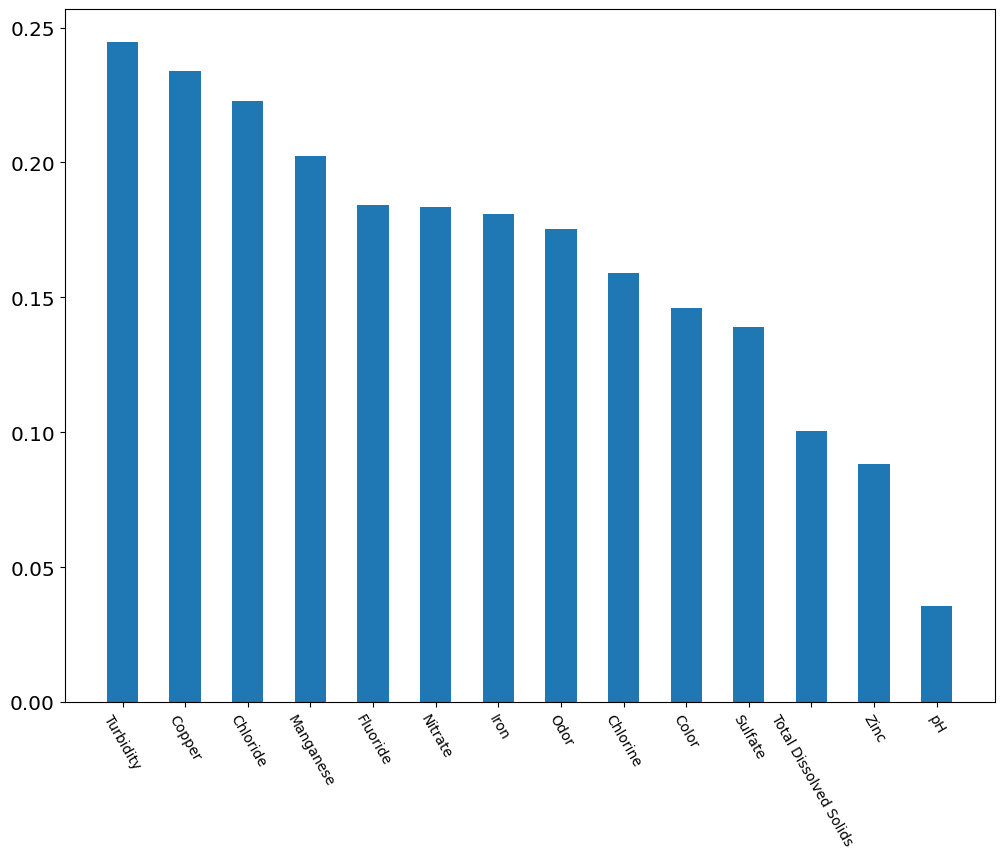

In [95]:
# 相关性分析
bar = df.corr()['Target'].abs().sort_values(ascending=False)[1:]

plt.bar(bar.index, bar, width=0.5)
# 设置figsize的大小
pos_list = np.arange(len(df.columns))
params = {
    'figure.figsize': '20, 10'
}
plt.rcParams.update(params)
plt.xticks(bar.index, bar.index, rotation=-60, fontsize=10)
plt.show()



In [4]:
# 删除不相关的列
df = df.drop(
    columns=['Index', 'Day', 'Time of Day', 'Month', 'Water Temperature', 'Source', 'Conductivity', 'Air Temperature'])

df

NameError: name 'df' is not defined

In [81]:
display(df.isna().sum())
missing = df.isna().sum().sum()
duplicates = df.duplicated().sum()
print("\nThere are {:,.0f} missing values in the data.".format(missing))
print("There are {:,.0f} duplicate records in the data.".format(duplicates))

pH                        116004
Iron                       39744
Nitrate                   105677
Chloride                  175414
Lead                       26909
Zinc                      156037
Color                          0
Turbidity                  49804
Fluoride                  189019
Copper                    199210
Odor                      178745
Sulfate                   197265
Chlorine                   57814
Manganese                 109525
Total Dissolved Solids      1670
Target                         0
dtype: int64


There are 1,602,837 missing values in the data.
There are 0 duplicate records in the data.


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956842 entries, 0 to 5956841
Data columns (total 16 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   pH                      float64
 1   Iron                    float64
 2   Nitrate                 float64
 3   Chloride                float64
 4   Lead                    float64
 5   Zinc                    float64
 6   Color                   int64  
 7   Turbidity               float64
 8   Fluoride                float64
 9   Copper                  float64
 10  Odor                    float64
 11  Sulfate                 float64
 12  Chlorine                float64
 13  Manganese               float64
 14  Total Dissolved Solids  float64
 15  Target                  int64  
dtypes: float64(14), int64(2)
memory usage: 727.2 MB


数据集缺失值比较多，需要进一步处理。

In [83]:
df = df.dropna()
df = df.drop_duplicates()

In [84]:
from scipy.stats import pearsonr

a = df.isnull().sum() / len(df)

variables = df.columns
df = df
for i in range(0, len(variables)):
    if a[i] >= 0.2:  #大于 20%
        print(variables[i])
        df = df.drop(variables[i], 1)

var = df.var()
numeric = df.columns
df = df.fillna(0)
for i in range(0, len(var) - 1):
    if var[i] <= 0.1:  # 方差大于10％
        print(variables[i])
        df = df.drop(numeric[i], 1)
variables = df.columns

for i in range(0, len(variables)):
    x = df[variables[i]]
    y = df[variables[-1]]
    if pearsonr(x, y)[1] > 0.05:
        print(variables[i])
        df = df.drop(variables[i], 1)

variables = df.columns
print(variables)
print(len(variables))

Lead
Index(['pH', 'Iron', 'Nitrate', 'Chloride', 'Zinc', 'Color', 'Turbidity',
       'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Chlorine', 'Manganese',
       'Total Dissolved Solids', 'Target'],
      dtype='object')
15


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
# 计算 Z-Score
scaler = Standardscaler()
data scaled = scaler.fit_transform(df)
z scores = np.abs(data scaled)
# 设置值
threshold = 3
# 去异常值df = df[(z scores < threshold).all(axis=1)]
print("Data without outliers:")print(df)



In [85]:

display(df.isna().sum())
missing = df.isna().sum().sum()
duplicates = df.duplicated().sum()
print("\nThere are {:,.0f} missing values in the data.".format(missing))
print("There are {:,.0f} duplicate records in the data.".format(duplicates))

pH                        0
Iron                      0
Nitrate                   0
Chloride                  0
Zinc                      0
Color                     0
Turbidity                 0
Fluoride                  0
Copper                    0
Odor                      0
Sulfate                   0
Chlorine                  0
Manganese                 0
Total Dissolved Solids    0
Target                    0
dtype: int64


There are 0 missing values in the data.
There are 0 duplicate records in the data.


0    3067414
1    1325268
Name: Target, dtype: int64


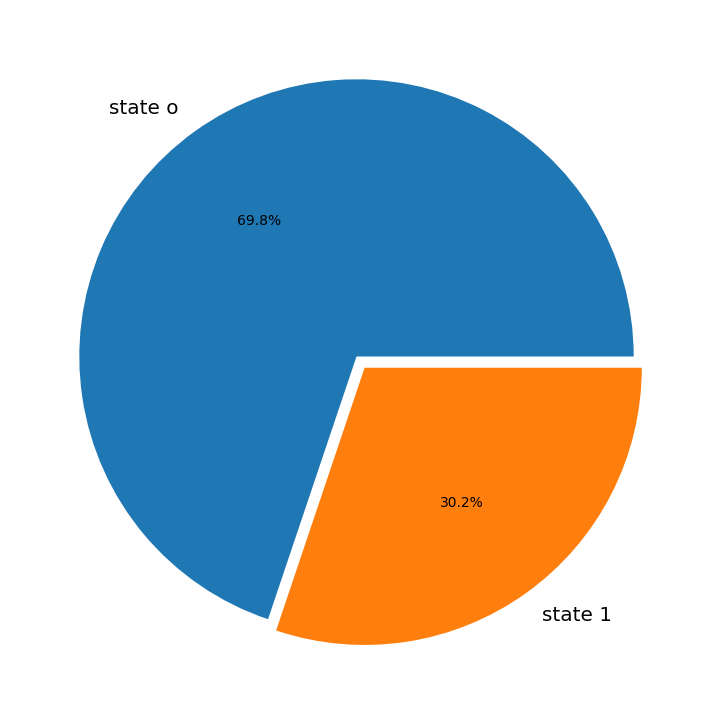

In [86]:
print(df.Target.value_counts())
target = df.Target.value_counts()
target.rename(index={1: 'state 1', 0: 'state o'}, inplace=True)
plt.pie(target, [0, 0.05], target.index, autopct='%1.1f%%')
plt.show()

In [87]:
from sklearnex import patch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [33]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import recall_score,precision_score,accuracy_score,roc_curve,roc_auc_score,f1_score,make_scorer,confusion_matrix

In [88]:
from imblearn.under_sampling import RandomUnderSampler
import datetime

X = df.iloc[:, 0:len(df.columns.tolist()) - 1].values
y = df.iloc[:, len(df.columns.tolist()) - 1].values

# # 下采样
under_sampler = RandomUnderSampler(random_state=21)
X, y = under_sampler.fit_resample(X, y)

X = df.drop('Target', axis=1)
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Train Shape: {}".format(X_train_scaled.shape))
print("Test Shape: {}".format(X_test_scaled.shape))

X_train, X_test = X_train_scaled, X_test_scaled

# from imblearn.over_sampling import SMOTE
# from collections import Counter
# sm = SMOTE(random_state=42)#
# print('Original dataset shape %s' % Counter(y_train))
# X_res, y_res = sm.fit_resample(X_train, y_train)
# print('Resampled dataset shape %s' % Counter(y_res))




Train Shape: (3514145, 14)
Test Shape: (878537, 14)


In [19]:
# param_grid = {
#     'max_depth': [8, 10, 12],
#     "gamma": [0, 1, 2],
#     "subsample": [0.3, 0.5, 1],
#     "colsample_bytree": [0.3, 0.5, 1],
#     'min_child_weight': [4, 5],
#     "n_estimators": [10, 20, 30, 50],
#     "alpha": [0, 2, 4, 10]
# }
#
#
# start_time = datetime.datetime.now()
# gsearch = GridSearchCV(xgb, param_grid, verbose=100, cv=3, scoring='f1')
# gsearch.fit(X_train, y_train)
# print(gsearch.best_params_)
# print(gsearch.best_score_)
# print(gsearch.best_estimator_)
# print(datetime.datetime.now() - start_time)

In [89]:
from sklearn.metrics import make_scorer

param_grid = {
    'max_depth': [10, 15, 20],
#     "gamma": [0, 1, 2], # -> 0
#     "subsample": [0.9, 1], # -> 1
#     "colsample_bytree": [0.3, 0.5, 1], # -> 1
#     'min_child_weight': [4, 6, 8], # -> 6
#     "n_estimators": [10、50, 80, 100], # -> 80
#     "alpha": [3, 4, 5] # -> 4
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc_score': make_scorer(roc_auc_score),
}

# {'subsample': 0.5, 'n_estimators': 10, 'min_child_weight': 5, 'max_depth': 12, 'gamma': 0, 'colsample_bytree': 1, 'alpha': 4}
# {'subsample': 0.6, 'n_estimators': 5, 'min_child_weight': 2, 'max_depth': 12, 'alpha': 4}
# {'subsample': 1, 'n_estimators': 6, 'min_child_weight': 4, 'max_depth': 15, 'alpha': 4}
# {'n_estimators': 10, 'min_child_weight': 6, 'max_depth': 15}
# {'n_estimators': 20, 'min_child_weight': 6, 'max_depth': 20}
# {'n_estimators': 80, 'min_child_weight': 6, 'max_depth': 100}
# {'n_estimators': 80, 'min_child_weight': 6, 'max_depth': 100}
# {'max_depth': 15}


xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=15,
    max_depth=12,
    min_child_weight=6,
    gamma=0,
    subsample=1,
    colsample_bytree=1,
    objective='binary:logistic',
    nthread=4,
    alpha=4,
    scale_pos_weight=1,
    seed=27)

In [31]:
refit_score = "f1_score"

start_time = datetime.datetime.now()
print(start_time)
rd_search = RandomizedSearchCV(xgb, param_grid, n_iter=10, cv=3, refit=refit_score, scoring=scorers, verbose=10,
                               return_train_score=True)
rd_search.fit(X_train, y_train)
print(rd_search.best_params_)
print(rd_search.best_score_)
print(rd_search.best_estimator_)
print(datetime.datetime.now() - start_time)

2023-06-09 15:41:14.309333
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3; 1/1] START max_depth=20................................................
[CV 1/3; 1/1] END max_depth=20; accuracy_score: (train=0.882, test=0.882) f1_score: (train=0.833, test=0.833) precision_score: (train=0.727, test=0.727) recall_score: (train=0.975, test=0.975) roc_auc_score: (train=0.909, test=0.909) total time= 2.1min
[CV 2/3; 1/1] START max_depth=20................................................
[CV 2/3; 1/1] END max_depth=20; accuracy_score: (train=0.882, test=0.882) f1_score: (train=0.833, test=0.833) precision_score: (train=0.727, test=0.727) recall_score: (train=0.976, test=0.975) roc_auc_score: (train=0.909, test=0.909) total time= 2.1min
[CV 3/3; 1/1] START max_depth=20................................................
[CV 3/3; 1/1] END max_depth=20; accuracy_score: (train=0.882, test=0.882) f1_score: (train=0.833, test=0.833) precision_score: (train=0.727, test=0.727) recall_score

In [56]:
param_grid = {
    #     'min_samples_split': [2, 3, 5, 10],
    'min_samples_split': [2,5,10],
    'n_estimators' : [30,50],
    'max_depth': [10,15],
    'max_features': [10, 15]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc_score': make_scorer(roc_auc_score),
}

In [ ]:
classifier = RandomForestClassifier(criterion = 'entropy', oob_score=True,random_state = 42)

refit_score = "f1_score"

start_time = datetime.datetime.now()
print(start_time)
rd_search = RandomizedSearchCV(classifier, param_grid, n_iter=2, cv=3, refit=refit_score, scoring="f1", verbose=10,
                               return_train_score=True)
rd_search.fit(X_train, y_train)
print(rd_search.best_params_)
print(rd_search.best_score_)
print(rd_search.best_estimator_)
print(datetime.datetime.now() - start_time)

In [90]:
xgb.fit(X_train, y_train)

XGBClassifier(alpha=4, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=6,
              missing=nan, monotone_constraints='()', n_estimators=15, n_jobs=4,
              nthread=4, num_parallel_tree=1, predictor='auto', random_state=27, ...)

In [91]:
y_pred = xgb.predict(X_test)

# confusion matrix on the test data.
print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                   columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))


Confusion matrix of Random Forest optimized for f1_score on the test data:
     pred_neg  pred_pos
neg    516811     97013
pos      7714    256999


<Figure size 1200x900 with 0 Axes>

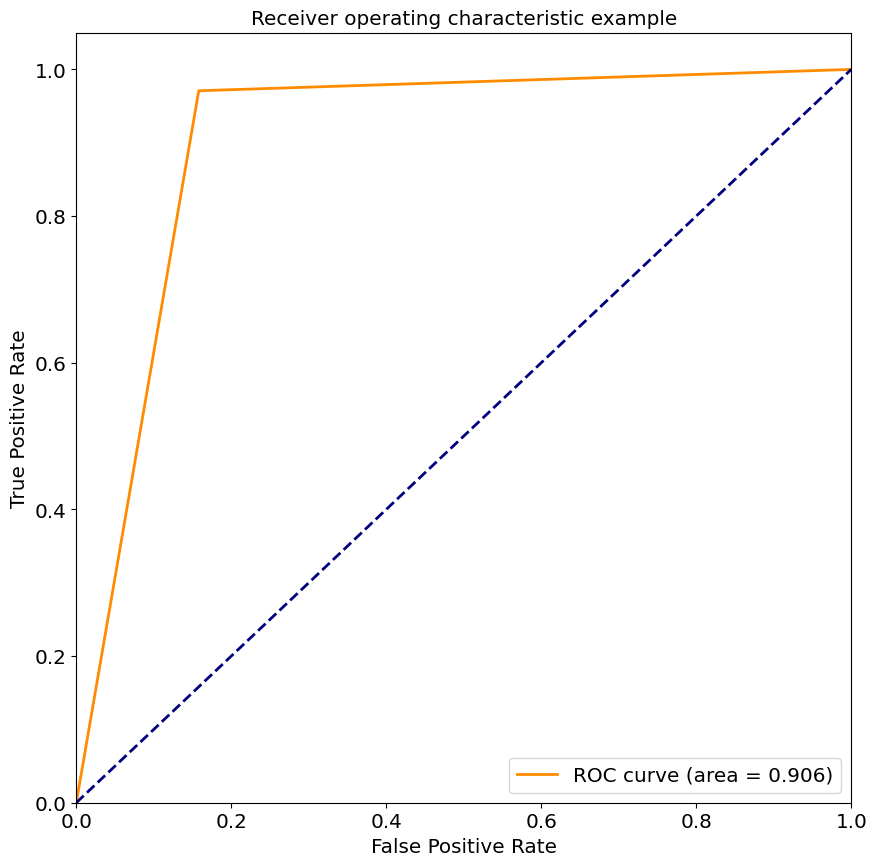

In [92]:
def acu_curve(y, prob):
    fpr, tpr, threshold = roc_curve(y, prob)  ###计算真正率和假正率
    roc_auc = auc(fpr, tpr)  ###计算auc的值

    plt.figure()
    lw = 2
    plt.figure(figsize=(10, 10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)  ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

    plt.show()


acu_curve(y_test, y_pred)

In [93]:
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))

print(roc_auc_score(y_test, randomForestClf.predict_proba(X_test)[:, 1]))
print(f1_score(y_test, y_pred))

0.8807938652555328
0.9708590057911776
0.8901007418588932
0.8307374035314559


In [ ]:
from scipy import interp

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 9),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)



tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

skf = StratifiedKFold(n_splits=5)
linetypes = ['--',':','-.','-','-','O']

i = 0
for train, test in skf.split(X_test, y_test):
    probas_ = randomForestClf.predict_proba(X_test[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1.5,linestyle = linetypes[i], alpha=0.8,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='r',
         label='Chance', alpha=.6)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('FPR',fontsize=20)
plt.ylabel('TPR',fontsize=20)
# plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


7.1 与SVM算法比较

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [73]:
dt_start = time.time()
randomForestClf = RandomForestClassifier()
randomForestClf.fit(X_train, y_train)
y_pred = randomForestClf.predict(X_test)
print("roc:",roc_auc_score(y_test, randomForestClf.predict_proba(X_test)[:,1]))
print("accuracy:",accuracy_score(y_test, y_pred))
print("recall:",recall_score(y_test, y_pred))
print("f1:",f1_score(y_test, y_pred))

print("RandomForestClassifier随机森林统计耗时: ", time.time() - dt_start)

roc: 0.9181803039038834
accuracy: 0.8817560332898448
recall: 0.9714380103152385
f1: 0.8322676904646008
RandomForestClassifier随机森林统计耗时:  109.1495668888092


In [53]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("roc:",roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
print("accuracy:",accuracy_score(y_test, y_pred))
print("recall:",recall_score(y_test, y_pred))
print("f1:",f1_score(y_test, y_pred))

roc: 0.7880033913269932
accuracy: 0.8234669840731984
recall: 0.6984572709330705
f1: 0.7049794111517539


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("roc:", roc_auc_score(y_test, randomForestClf.pre dict_proba(X_test)[:, 1]))
print("accuracy:", accuracy_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
print("f1:", f1_score(y_test, y_pred))

In [ ]:

importances = randomForestClf.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
""
print("Feature importance ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()
